In [1]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import re

# data load

In [2]:
# 구글 드라이브 공유 링크에서 파일 ID를 가져옵니다.
file_id = '1ZUueEhjvhzmo8UpZLwqMgzMKA6FGtLJk'  # 여기에 파일 ID를 입력하세요.
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# 파일 다운로드
response = requests.get(download_url)
response.raise_for_status()  # 요청이 실패하면 예외를 발생시킵니다.

# 다운로드한 ZIP 파일을 메모리에서 직접 압축 해제합니다.
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall('/content/unzipped_folder')

# 결과 확인
import os
os.listdir('/content/unzipped_folder')


['test.csv', 'sample_submission.csv', 'train.csv']

In [3]:
# 데이터 불러오기
#df = pd.read_csv("/content/unzipped_folder/train.csv")
train = pd.read_csv("/content/unzipped_folder/train.csv")
test = pd.read_csv("/content/unzipped_folder/test.csv")

# preprocessing

## NaN

In [4]:
# NaN 값을 'WT'로 치환
train.fillna('WT', inplace=True)
test.fillna('WT', inplace=True)

train_nan = train.isna().sum().sum()
print(f"처리 후 train NaN 개수: {train_nan}")

test_nan = test.isna().sum().sum()
print(f"처리 후 test NaN 개수: {test_nan}")

처리 후 train NaN 개수: 0
처리 후 test NaN 개수: 0


## variant types

### category1

In [5]:
def process_value1(value):
    # 1) WT 그대로 유지
    if value == 'WT':
        return value

    parts = value.split()
    processed_parts = []

    for part in parts:
        # 패턴: 문자 그룹 + 숫자 + 문자 그룹
        match = re.match(r'^([A-Za-z*-]*)\d+([A-Za-z*-]*)$', part)

        if match:
            prefix = match.group(1)  # 숫자 앞의 문자 그룹
            suffix = match.group(2)   # 숫자 뒤의 문자 그룹

            # 1. 숫자 앞뒤의 문자 그룹이 같으면 WT로 치환
            if prefix.isupper() and suffix.isupper() and prefix == suffix:
                continue

            # 2. 앞뒤 문자 그룹이 다르면 missense로 분류
            elif prefix.isupper() and suffix.isupper() and prefix != suffix:
                processed_parts.append('missense')

            # 3. 뒤의 문자 그룹에 '*'이 들어가면 nonsense로 치환
            elif '*' in suffix:
                processed_parts.append('nonsense')

            # 4. 뒤의 문자 그룹에 'fs'가 들어가면 frameshift로 치환
            elif 'fs' in suffix:
                processed_parts.append('frameshift')

            # 5. 뒤에 문자 그룹에 'del'이 들어가면 deletion으로 치환
            elif 'delins' in suffix:
                processed_parts.append('delins')

            # 5. 뒤에 문자 그룹에 'del'이 들어가면 deletion으로 치환
            elif 'del' in suffix:
                processed_parts.append('deletion')

            # 5. 뒤에 문자 그룹에 'del'이 들어가면 deletion으로 치환
            elif 'ins' in suffix:
                processed_parts.append('insertion')

            # 6. 뒤에 문자그룹이 없으면 deletion으로 치환
            elif not(suffix):
                processed_parts.append('deletion')

            else:
                print(part)

        # 해당 카테고리가 아니면 그대로 유지
        else:
          processed_parts.append(part)

    # 처리된 부분이 없으면 WT로 변경
    result = 'WT' if not processed_parts else ' '.join(processed_parts)

    return result

In [6]:
# train 데이터프레임 전처리
for col in train.columns[2:]:  # ID와 SUBCLASS 제외
    train[col] = train[col].apply(process_value1)

# 최종 데이터 확인
print(train)

              ID SUBCLASS A2M AAAS AADAT AARS1 ABAT ABCA1 ABCA2 ABCA3  ...  \
0     TRAIN_0000    KIPAN  WT   WT    WT    WT   WT    WT    WT    WT  ...   
1     TRAIN_0001     SARC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
2     TRAIN_0002     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   
3     TRAIN_0003     KIRC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
4     TRAIN_0004   GBMLGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
...          ...      ...  ..  ...   ...   ...  ...   ...   ...   ...  ...   
6196  TRAIN_6196     LUAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6197  TRAIN_6197      LGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6198  TRAIN_6198     COAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6199  TRAIN_6199     TGCT  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6200  TRAIN_6200     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   

     ZNF292 ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4 ZPBP ZW10     ZWIN

In [7]:
# test 데이터프레임 전처리
for col in test.columns[1:]:  # ID 제외
    test[col] = test[col].apply(process_value1)

# 최종 데이터 확인
print(test)

             ID A2M AAAS AADAT AARS1 ABAT     ABCA1 ABCA2     ABCA3     ABCA4  \
0     TEST_0000  WT   WT    WT    WT   WT        WT    WT        WT        WT   
1     TEST_0001  WT   WT    WT    WT   WT  missense    WT        WT        WT   
2     TEST_0002  WT   WT    WT    WT   WT        WT    WT        WT        WT   
3     TEST_0003  WT   WT    WT    WT   WT        WT    WT        WT        WT   
4     TEST_0004  WT   WT    WT    WT   WT        WT    WT        WT        WT   
...         ...  ..  ...   ...   ...  ...       ...   ...       ...       ...   
2541  TEST_2541  WT   WT    WT    WT   WT        WT    WT        WT        WT   
2542  TEST_2542  WT   WT    WT    WT   WT        WT    WT        WT        WT   
2543  TEST_2543  WT   WT    WT    WT   WT  missense    WT  missense  missense   
2544  TEST_2544  WT   WT    WT    WT   WT        WT    WT        WT  missense   
2545  TEST_2545  WT   WT    WT    WT   WT        WT    WT        WT        WT   

      ...                 Z

### category2

In [8]:
def process_value2(value):
    # 1) WT 그대로 유지
    if value == 'WT':
        return value

    parts = value.split()
    processed_parts = []

    for part in parts:
        # 패턴: 숫자_숫자 + 변이정보
        match = re.match(r'^\d+_\d+([A-Za-z*-]+>[A-Za-z*-]+|del)$', part)

        if match:
            variant = match.group(1)  # 변이 정보 그룹


            # 1. >가 있는 경우
            if '>' in variant:
                before, after = variant.split('>')  # '>' 기준으로 나눔
                # 1.1 문자 그룹이 같은 경우 -> WT
                if before.isupper() and after.isupper() and before == after:
                    continue
                # 1.2 문자 그룹이 다른 경우 -> missense
                elif before.isupper() and after.isupper() and before != after:
                    processed_parts.append('missense')
                # 1.3 *가 있는 경우 -> nonsense
                elif '*' in after:
                    processed_parts.append('nonsense')
                # 1.4 fs가 있는 경우 -> frameshift
                elif 'fs' in after:
                    processed_parts.append('frameshift')
                else:
                    print(part)

            # 2. >가 없는 경우
            elif 'del' in variant:
                processed_parts.append('deletion')

            else:
                print(part)

        # 해당 카테고리가 아니면 그대로 유지
        else:
          processed_parts.append(part)


    # 처리된 부분이 없으면 WT로 변경
    result = 'WT' if not processed_parts else ' '.join(processed_parts)

    return result

In [9]:
# train 데이터프레임 전처리
for col in train.columns[2:]:  # ID와 SUBCLASS 제외
    train[col] = train[col].apply(process_value2)

# 최종 데이터 확인
print(train)

              ID SUBCLASS A2M AAAS AADAT AARS1 ABAT ABCA1 ABCA2 ABCA3  ...  \
0     TRAIN_0000    KIPAN  WT   WT    WT    WT   WT    WT    WT    WT  ...   
1     TRAIN_0001     SARC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
2     TRAIN_0002     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   
3     TRAIN_0003     KIRC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
4     TRAIN_0004   GBMLGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
...          ...      ...  ..  ...   ...   ...  ...   ...   ...   ...  ...   
6196  TRAIN_6196     LUAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6197  TRAIN_6197      LGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6198  TRAIN_6198     COAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6199  TRAIN_6199     TGCT  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6200  TRAIN_6200     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   

     ZNF292 ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4 ZPBP ZW10     ZWIN

In [10]:
# test 데이터프레임 전처리
for col in test.columns[1:]:  # ID 제외
    test[col] = test[col].apply(process_value2)

# 최종 데이터 확인
print(test)

             ID A2M AAAS AADAT AARS1 ABAT     ABCA1 ABCA2     ABCA3     ABCA4  \
0     TEST_0000  WT   WT    WT    WT   WT        WT    WT        WT        WT   
1     TEST_0001  WT   WT    WT    WT   WT  missense    WT        WT        WT   
2     TEST_0002  WT   WT    WT    WT   WT        WT    WT        WT        WT   
3     TEST_0003  WT   WT    WT    WT   WT        WT    WT        WT        WT   
4     TEST_0004  WT   WT    WT    WT   WT        WT    WT        WT        WT   
...         ...  ..  ...   ...   ...  ...       ...   ...       ...       ...   
2541  TEST_2541  WT   WT    WT    WT   WT        WT    WT        WT        WT   
2542  TEST_2542  WT   WT    WT    WT   WT        WT    WT        WT        WT   
2543  TEST_2543  WT   WT    WT    WT   WT  missense    WT  missense  missense   
2544  TEST_2544  WT   WT    WT    WT   WT        WT    WT        WT  missense   
2545  TEST_2545  WT   WT    WT    WT   WT        WT    WT        WT        WT   

      ...                 Z

### category3

In [11]:
def process_value3(value):
    # 1) WT 그대로 유지
    if value == 'WT':
        return value

    parts = value.split()
    processed_parts = []

    for part in parts:
        # 패턴: 숫자_숫자 + 변이정보
        match = re.match(r'^([A-Za-z]+)\d+_([A-Za-z]+)?\d+([A-Za-z]+)$', part)

        if match:
            variant = match.group(3)  # 변이 정보 그룹

            # 1. >가 있는 경우
            if 'del' in variant and 'ins' in variant:
                processed_parts.append('delins')

            elif 'del' in variant and not('ins' in variant):
                processed_parts.append('deletion')

            elif 'ins' in variant and not('del' in variant):
                processed_parts.append('insertion')

            else:
                print(part)

        # 해당 카테고리가 아니면 그대로 유지
        else:
          processed_parts.append(part)

    # 처리된 부분이 없으면 WT로 변경
    result = 'WT' if not processed_parts else ' '.join(processed_parts)

    return result

In [12]:
# train 데이터프레임 전처리
for col in train.columns[2:]:  # ID와 SUBCLASS 제외
    train[col] = train[col].apply(process_value3)

# 최종 데이터 확인
print(train)

              ID SUBCLASS A2M AAAS AADAT AARS1 ABAT ABCA1 ABCA2 ABCA3  ...  \
0     TRAIN_0000    KIPAN  WT   WT    WT    WT   WT    WT    WT    WT  ...   
1     TRAIN_0001     SARC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
2     TRAIN_0002     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   
3     TRAIN_0003     KIRC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
4     TRAIN_0004   GBMLGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
...          ...      ...  ..  ...   ...   ...  ...   ...   ...   ...  ...   
6196  TRAIN_6196     LUAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6197  TRAIN_6197      LGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6198  TRAIN_6198     COAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6199  TRAIN_6199     TGCT  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6200  TRAIN_6200     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   

     ZNF292 ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4 ZPBP ZW10     ZWIN

In [13]:
# test 데이터프레임 전처리
for col in test.columns[1:]:  # ID 제외
    test[col] = test[col].apply(process_value3)

# 최종 데이터 확인
print(test)

             ID A2M AAAS AADAT AARS1 ABAT     ABCA1 ABCA2     ABCA3     ABCA4  \
0     TEST_0000  WT   WT    WT    WT   WT        WT    WT        WT        WT   
1     TEST_0001  WT   WT    WT    WT   WT  missense    WT        WT        WT   
2     TEST_0002  WT   WT    WT    WT   WT        WT    WT        WT        WT   
3     TEST_0003  WT   WT    WT    WT   WT        WT    WT        WT        WT   
4     TEST_0004  WT   WT    WT    WT   WT        WT    WT        WT        WT   
...         ...  ..  ...   ...   ...  ...       ...   ...       ...       ...   
2541  TEST_2541  WT   WT    WT    WT   WT        WT    WT        WT        WT   
2542  TEST_2542  WT   WT    WT    WT   WT        WT    WT        WT        WT   
2543  TEST_2543  WT   WT    WT    WT   WT  missense    WT  missense  missense   
2544  TEST_2544  WT   WT    WT    WT   WT        WT    WT        WT  missense   
2545  TEST_2545  WT   WT    WT    WT   WT        WT    WT        WT        WT   

      ...                 Z

## mutation counts

In [14]:
# 변이 횟수를 계산하는 함수 정의
def count_mutations(row):
    mutation_count = 0
    for val in row:
        if val != 'WT':
            # 공백으로 나누어진 패턴 개수를 모두 더하기
            mutation_count += len(val.split())
    return mutation_count

In [15]:
# 각 ID별로 변이 횟수 측정하여 새로운 열 추가
train['Mutation_Count'] = train.iloc[:, 2:].apply(count_mutations, axis=1)

# 최종 데이터 확인
print(train)

              ID SUBCLASS A2M AAAS AADAT AARS1 ABAT ABCA1 ABCA2 ABCA3  ...  \
0     TRAIN_0000    KIPAN  WT   WT    WT    WT   WT    WT    WT    WT  ...   
1     TRAIN_0001     SARC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
2     TRAIN_0002     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   
3     TRAIN_0003     KIRC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
4     TRAIN_0004   GBMLGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
...          ...      ...  ..  ...   ...   ...  ...   ...   ...   ...  ...   
6196  TRAIN_6196     LUAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6197  TRAIN_6197      LGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6198  TRAIN_6198     COAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6199  TRAIN_6199     TGCT  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6200  TRAIN_6200     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   

     ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4 ZPBP ZW10     ZWINT ZYX M

<ipython-input-15-3f168bf7411b>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['Mutation_Count'] = train.iloc[:, 2:].apply(count_mutations, axis=1)


In [16]:
# 각 ID별로 변이 횟수 측정하여 새로운 열 추가
test['Mutation_Count'] = test.iloc[:, 1:].apply(count_mutations, axis=1)

# 최종 데이터 확인
print(test)

             ID A2M AAAS AADAT AARS1 ABAT     ABCA1 ABCA2     ABCA3     ABCA4  \
0     TEST_0000  WT   WT    WT    WT   WT        WT    WT        WT        WT   
1     TEST_0001  WT   WT    WT    WT   WT  missense    WT        WT        WT   
2     TEST_0002  WT   WT    WT    WT   WT        WT    WT        WT        WT   
3     TEST_0003  WT   WT    WT    WT   WT        WT    WT        WT        WT   
4     TEST_0004  WT   WT    WT    WT   WT        WT    WT        WT        WT   
...         ...  ..  ...   ...   ...  ...       ...   ...       ...       ...   
2541  TEST_2541  WT   WT    WT    WT   WT        WT    WT        WT        WT   
2542  TEST_2542  WT   WT    WT    WT   WT        WT    WT        WT        WT   
2543  TEST_2543  WT   WT    WT    WT   WT  missense    WT  missense  missense   
2544  TEST_2544  WT   WT    WT    WT   WT        WT    WT        WT  missense   
2545  TEST_2545  WT   WT    WT    WT   WT        WT    WT        WT        WT   

      ...    ZNF365 ZNF639 

<ipython-input-16-51da2288274d>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['Mutation_Count'] = test.iloc[:, 1:].apply(count_mutations, axis=1)


In [17]:
# 전처리한 df를 CSV 파일로 저장
train.to_csv('processed_train.csv', index=False)
test.to_csv('processed_test.csv', index=False)
print("CSV 파일로 저장되었습니다.")

CSV 파일로 저장되었습니다.


# test - train

In [18]:
import pandas as pd

# 차집합을 저장할 딕셔너리 초기화
difference_dict = {}

# 마지막 열을 제외한 열 목록 추출
columns_to_compare = train.columns[:-1]

# 각 열에 대해 차집합 계산
for column in columns_to_compare:
    if column in test.columns:  # test에 해당 열이 있을 경우만 진행
        # train의 고유 값 (띄어쓰기로 분리한 후 유니크 값 추출)
        train_values = set()
        train[column].dropna().apply(lambda x: train_values.update(str(x).split()) if isinstance(x, str) else None)

        # test의 고유 값 (띄어쓰기로 분리한 후 유니크 값 추출)
        test_values = set()
        test[column].dropna().apply(lambda x: test_values.update(str(x).split()) if isinstance(x, str) else None)

        # 차집합 계산 (test에만 존재하는 값)
        difference = test_values - train_values

        # 차집합이 있을 경우 딕셔너리에 저장
        if difference:
            difference_dict[column] = difference

# 결과 출력
for column, diff in difference_dict.items():
    print(f'Column: {column}, Difference: {diff}')


Column: ID, Difference: {'TEST_1601', 'TEST_1434', 'TEST_1890', 'TEST_1426', 'TEST_2393', 'TEST_2445', 'TEST_1535', 'TEST_0054', 'TEST_0697', 'TEST_1368', 'TEST_2058', 'TEST_2012', 'TEST_1151', 'TEST_1445', 'TEST_1886', 'TEST_2347', 'TEST_1195', 'TEST_0692', 'TEST_1540', 'TEST_1293', 'TEST_1563', 'TEST_0817', 'TEST_1557', 'TEST_2223', 'TEST_2291', 'TEST_1316', 'TEST_0854', 'TEST_0207', 'TEST_0891', 'TEST_0439', 'TEST_1158', 'TEST_0575', 'TEST_0631', 'TEST_0238', 'TEST_1013', 'TEST_1447', 'TEST_0592', 'TEST_0027', 'TEST_1338', 'TEST_1795', 'TEST_0849', 'TEST_1468', 'TEST_2254', 'TEST_0649', 'TEST_2501', 'TEST_0155', 'TEST_2099', 'TEST_0530', 'TEST_2005', 'TEST_1243', 'TEST_0968', 'TEST_1354', 'TEST_1367', 'TEST_0089', 'TEST_2476', 'TEST_0499', 'TEST_0456', 'TEST_1770', 'TEST_2470', 'TEST_1343', 'TEST_0113', 'TEST_0956', 'TEST_1364', 'TEST_0875', 'TEST_1779', 'TEST_1516', 'TEST_1238', 'TEST_2358', 'TEST_2481', 'TEST_0680', 'TEST_1532', 'TEST_0964', 'TEST_2093', 'TEST_0999', 'TEST_0629', 

# train - test

In [19]:
import pandas as pd

# 차집합을 저장할 딕셔너리 초기화
difference_dict = {}

# 마지막 열을 제외한 열 목록 추출
columns_to_compare = test.columns[:-1]

# 각 열에 대해 차집합 계산
for column in columns_to_compare:
    if column in train.columns:  # test에 해당 열이 있을 경우만 진행
        # train의 고유 값 (띄어쓰기로 분리한 후 유니크 값 추출)
        train_values = set()
        train[column].dropna().apply(lambda x: train_values.update(str(x).split()) if isinstance(x, str) else None)

        # test의 고유 값 (띄어쓰기로 분리한 후 유니크 값 추출)
        test_values = set()
        test[column].dropna().apply(lambda x: test_values.update(str(x).split()) if isinstance(x, str) else None)

        # 차집합 계산 (train에만 존재하는 값)
        difference = train_values - test_values

        # 차집합이 있을 경우 딕셔너리에 저장
        if difference:
            difference_dict[column] = difference

# 결과 출력
for column, diff in difference_dict.items():
    print(f'Column: {column}, Difference: {diff}')


Column: ID, Difference: {'TRAIN_6075', 'TRAIN_4104', 'TRAIN_1459', 'TRAIN_2886', 'TRAIN_0677', 'TRAIN_1604', 'TRAIN_2396', 'TRAIN_4724', 'TRAIN_1560', 'TRAIN_4354', 'TRAIN_1875', 'TRAIN_0595', 'TRAIN_1821', 'TRAIN_4899', 'TRAIN_5875', 'TRAIN_2974', 'TRAIN_3420', 'TRAIN_4841', 'TRAIN_3550', 'TRAIN_0655', 'TRAIN_5300', 'TRAIN_0376', 'TRAIN_0140', 'TRAIN_5699', 'TRAIN_4829', 'TRAIN_2249', 'TRAIN_1063', 'TRAIN_2349', 'TRAIN_0320', 'TRAIN_5681', 'TRAIN_1389', 'TRAIN_2540', 'TRAIN_2351', 'TRAIN_0074', 'TRAIN_0870', 'TRAIN_1539', 'TRAIN_2302', 'TRAIN_5942', 'TRAIN_3886', 'TRAIN_3079', 'TRAIN_0620', 'TRAIN_1013', 'TRAIN_0056', 'TRAIN_1308', 'TRAIN_0717', 'TRAIN_3502', 'TRAIN_3918', 'TRAIN_0187', 'TRAIN_1755', 'TRAIN_3588', 'TRAIN_0972', 'TRAIN_2730', 'TRAIN_3077', 'TRAIN_3284', 'TRAIN_1696', 'TRAIN_6066', 'TRAIN_3622', 'TRAIN_3259', 'TRAIN_4155', 'TRAIN_1160', 'TRAIN_5001', 'TRAIN_5112', 'TRAIN_5589', 'TRAIN_0856', 'TRAIN_3525', 'TRAIN_4185', 'TRAIN_3267', 'TRAIN_3257', 'TRAIN_1192', 'TRAIN_04

# dimension reduction

## Cramér's V
범주형 변수들 간의 연관성을 측정하는 통계적 지표.

두 범주형 변수 사이의 카이제곱 독립성 검정 결과를 기반으로

**0**은 변수 간 **연관성이 없음을**, **1**은 **완벽한 연관성**을 의미

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

# Cramér's V 계산 함수
def cramers_v(confusion_matrix):
    try:
        chi2, p, dof, expected = chi2_contingency(confusion_matrix)
        n = confusion_matrix.sum().sum()
        r, k = confusion_matrix.shape
        return np.sqrt(chi2 / (n * (min(r, k) - 1)))
    except Exception as e:
        print(f"Error calculating Cramér's V: {e}")
        return np.nan  # Return NaN in case of error

In [31]:
# 데이터프레임이 df라고 가정
df_features = train.drop(columns=['ID', 'SUBCLASS'])
df_target = train['SUBCLASS']

# Cramér's V 값이 0.3 이상인 피처만 저장할 딕셔너리 생성
significant_cramersv_dict = {}

# 오류가 발생한 피처를 저장할 리스트
error_features = []

# 각 열에 대해 Cramér's V 계산
for col in df_features.columns:
    # 교차표 생성
    confusion_matrix = pd.crosstab(df_target, df_features[col])

    # Cramér's V 값 계산
    cramers_v_value = cramers_v(confusion_matrix)

    # NaN 값 처리 및 오류 기록
    if pd.isna(cramers_v_value):
        error_features.append(col)
    else:
        if cramers_v_value >= 0.1:
            significant_cramersv_dict[col] = cramers_v_value

# Cramér's V 값을 DataFrame으로 변환
significant_features_df = pd.DataFrame.from_dict(significant_cramersv_dict, orient='index', columns=['Cramér’s V'])

# 오류 목록을 DataFrame으로 변환
error_features_df = pd.DataFrame(error_features, columns=['Feature'])


<ipython-input-20-3f38f4a78f89>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-20-3f38f4a78f89>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-20-3f38f4a78f89>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-20-3f38f4a78f89>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-20-3f38f4a78f89>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-20-3f38f4a78f89>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-20-3f38f4a78f89>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-20-3f38f4a78f89>:13: RuntimeWarning: inv

In [32]:
# CSV 파일로 저장
significant_features_df.to_csv('significant_features_1.csv', index=True)
error_features_df.to_csv('error_features.csv', index=False)

In [33]:
train_wt_columns = train.columns[(train == 'WT').all()].tolist()
test_wt_columns = test.columns[(test == 'WT').all()].tolist()

print('데이터셋에서 값이 모두 WT인 열 개수')
print('trainSet (', len(train_wt_columns), ') : ', train_wt_columns)
print('errorSet (', len(error_features), ') : ', error_features)
print('testSet (', len(test_wt_columns), ') : ', test_wt_columns)

데이터셋에서 값이 모두 WT인 열 개수
trainSet ( 159 ) :  ['AARS1', 'ACTN3', 'ADGRA2', 'ADGRE1', 'ADGRG1', 'ADGRL2', 'ADGRL4', 'ADH1C', 'AMIGO2', 'AP2S1', 'ATP5F1A', 'ATP5F1B', 'ATP5F1C', 'ATP5F1D', 'ATP5F1E', 'ATP5MC1', 'ATP5MC2', 'ATP5MC3', 'ATP5ME', 'ATP5MF', 'ATP5MG', 'ATP5PB', 'ATP5PD', 'ATP5PF', 'ATP5PO', 'BOLA2', 'CASP8AP2', 'CAVIN1', 'CAVIN2', 'CAVIN3', 'CCN1', 'CCN2', 'CCN5', 'CDSN', 'CEBPD', 'CNOT9', 'COQ8A', 'CROCCP2', 'CRYBG1', 'CTF1', 'CXCL16', 'DARS1', 'DENND2B', 'DMAC2L', 'DOP1A', 'EEF1AKMT1', 'EEIG1', 'ELOA', 'ELP1', 'EPRS1', 'ERO1A', 'ETFBKMT', 'FCMR', 'FYB1', 'G6PC1', 'GFUS', 'GPAT4', 'GPX1', 'GPX4', 'GRK2', 'GSDME', 'GUCY1A1', 'GUCY1B1', 'GYPA', 'H1-0', 'H1-2', 'H1-6', 'H2AC25', 'H2AJ', 'H2AX', 'H2AZ1', 'H2AZ2', 'H2BC12', 'H2BC3', 'H4C3', 'HBBP1', 'HYCC2', 'IARS1', 'IRAG2', 'JPT1', 'KARS1', 'KMT5A', 'KNL1', 'LARGE1', 'MACROH2A2', 'MAP3K20', 'MARCHF1', 'MARCHF2', 'MARCHF6', 'MARCHF8', 'MIGA2', 'MINDY1', 'MIX23', 'MMP12', 'MRE11', 'MST1', 'MT1E', 'MTARC2', 'MTREX', 'MYL11', 'NECTIN1',

In [34]:
# 차집합 계산
difference = set(train_wt_columns) - set(error_features)

# 결과 출력
print('train_wt_columns에 있지만 error_features_df에는 없는 열:')
print(difference)

# 차집합 계산
difference = set(error_features) - set(train_wt_columns)

# 결과 출력
print('error_features_df에 있지만 train_wt_columns에는 없는 열:')
print(difference)

train_wt_columns에 있지만 error_features_df에는 없는 열:
set()
error_features_df에 있지만 train_wt_columns에는 없는 열:
set()


--> 오류가 나타나는 구간은 전부 WT로 차있는 열인 것으로 확인.

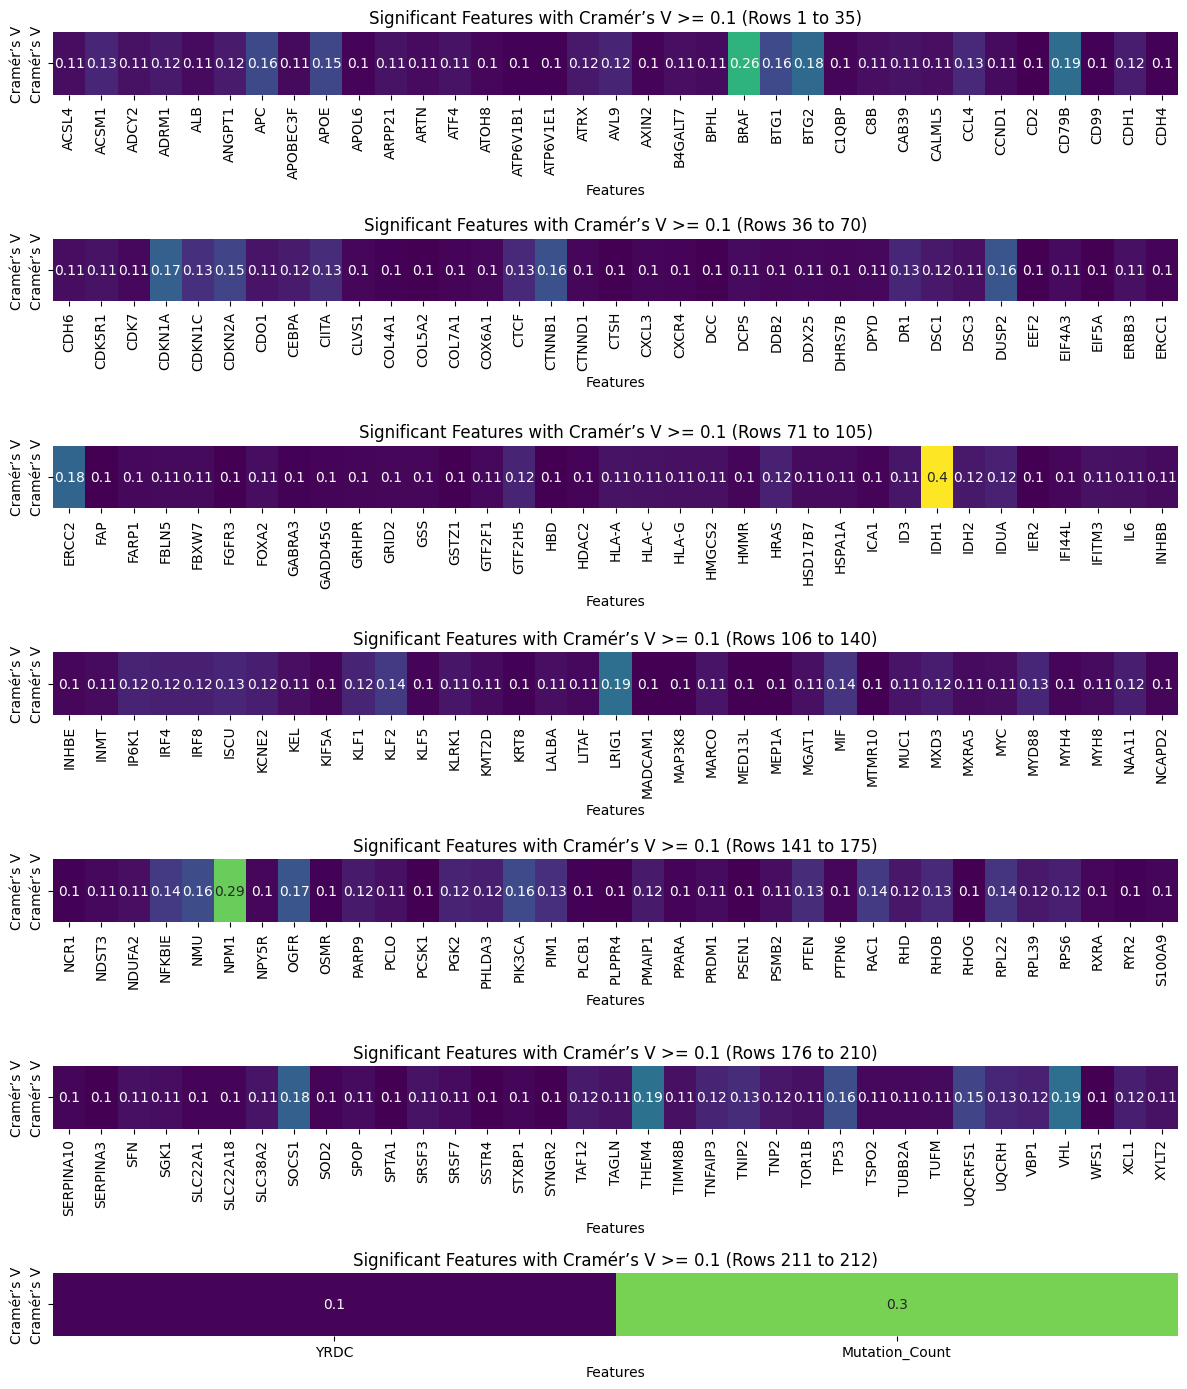

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Cramér's V 값이 0.1 ~ 0.36 사이로 색상 범위를 조정
cmap = sns.color_palette("viridis", as_cmap=True)
norm = plt.Normalize(vmin=0.1, vmax=0.35)


# 필터링된 피처의 Cramér's V 값을 한 줄에 35개씩 나누어 시각화
if not significant_features_df.empty:
    # 데이터프레임을 10개씩 나누어 리스트로 변환
    num_features_per_row = 35
    num_rows = int(np.ceil(len(significant_features_df) / num_features_per_row))

    plt.figure(figsize=(12, num_rows * 2))  # 높이는 필터링된 피처의 수에 따라 조절

    for i in range(num_rows):
        start_idx = i * num_features_per_row
        end_idx = min((i + 1) * num_features_per_row, len(significant_features_df))

        # 데이터 슬라이스
        subset_df = significant_features_df.iloc[start_idx:end_idx]

        # 각 슬라이스에 대한 heatmap 그리기
        plt.subplot(num_rows, 1, i + 1)
        sns.heatmap(subset_df.T, annot=True, cmap='viridis', norm=norm, vmin=0, vmax=1, cbar=False)
        plt.title(f'Significant Features with Cramér’s V >= 0.1 (Rows {start_idx+1} to {end_idx})')
        plt.xlabel('Features')
        plt.ylabel('Cramér’s V')

    plt.tight_layout()
    plt.show()
else:
    print("No features with Cramér’s V >= 0.1 found.")